In [1]:
from bs4 import BeautifulSoup as BS
import urllib.request
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
% matplotlib inline
import seaborn as sns

import geopandas as gpd
from shapely.geometry import Point

import datetime

In [2]:
class WebScrapingToDF(object):
    def __init__(self, url):
        self._url = url
    
    def start(self, table_class="sortable wikitable"):
        """
            1. make initial request
            2. turn the request into soup object
            3. get table
            4. from table get columns and rows
            5. return pandas dataframe of data obtained
        """
        url_html = self._make_request()
        soup = BS(url_html, 'html.parser')
        
        table = WebScrapingToDF._get_table(soup, table_class=table_class)
        
        columns = WebScrapingToDF._get_headers(table)
        rows = WebScrapingToDF._get_rows(table)
        
        return pd.DataFrame(data=rows, columns=columns)
    
    def _make_request(self):
        request = urllib.request.Request(self._url)
        result = urllib.request.urlopen(request)
        return result.read()
    
    @staticmethod
    def _get_table(soup, table_class):
        table_html = soup.find_all('table', class_=table_class)
        return table_html[0]
    
    @staticmethod
    def _get_headers(table):
        table_headers = table.find_all("th")
        return [th.text for th in table_headers]
    
    @staticmethod
    def _get_rows(table):
        rows = []
        for tr in table.find_all("tr")[1:]:
            row_data = [td.text for td in tr.find_all("td")]
            rows.append(row_data)
            
        return rows
    

# We are using data from multiple resources. Here is all the links we used to gather this info!!! Results are all dataframes :D 

In [3]:
# Gather earthquakes info
earthquakes_scraping = WebScrapingToDF(url="https://en.wikipedia.org/wiki/List_of_deadly_earthquakes_since_1900")
earthquakes = earthquakes_scraping.start()

In [4]:
# Gather volcano info
volcanoes_scraping = WebScrapingToDF(url="http://volcano.oregonstate.edu/volcano_table")
volcanoes = volcanoes_scraping.start(table_class="views-table cols-6")

In [5]:
# Gather vents info
vents_scraping = WebScrapingToDF(url="http://vents-data.interridge.org/ventfields_list_all")
vents = vents_scraping.start(table_class="views-table cols-8")

In [6]:
class CleanEarthquakes(object):
    def __init__(self, df):
        self._df = df
        
    def clean_col_by_regex(self, regex, column):
        self._df[column] = self._df[column].str.replace(regex, "")
        
    def clean_cols_by_extract(self, columns, regex):
        for col in columns:
            self._df[col] = self._df[col].str.extract(regex, expand=True)
        
    def convert_nan_lat_lng(self, is_nan):
        """There are son lat/lng values in the dataframe that didn't exist on the wiki page, so we looked up the coords
            and assigned them to their appropriate location

            First index is LNG, second is LAT
        """
        for loc, coords in is_nan.items():
            self._df.iloc[loc, self._df.columns.get_loc('lng')] = coords[0]
            self._df.iloc[loc, self._df.columns.get_loc('lat')] = coords[1]

        assert self._df[self._df["lat"].isnull()].empty == True
        assert self._df[self._df["lng"].isnull()].empty == True
        
    def convert_values_in_row_by_index(self, index, **kwargs):
        """There is a unique case where the lat/lng as well as depth values are '?' or '??'"""
        for key, value in kwargs.items():
            self._df.iloc[index, self._df.columns.get_loc(key)] = value    
            
    def get_mean_deaths(self, column):
        """There can potentially be multiple values within the Other Source Deaths column. So, this is grabbing the 
            values and determining the mean
        """
        means = []
        for row in self._df[column]:
            if isinstance(row, str):
                int_list = row.strip().split(" ")
                total = 0
                total = sum(list(map(int, map(float, int_list))))

                mean = total / len(int_list)
                means.append(mean)
            else:
                means.append(row)

        self._df[column] = means
        
    def nan_to_float32(self, columns, value=0, inplace=True):    
        for col in columns:        
            self._df[col].fillna(value=value, inplace=inplace)
            self._df[col] = pd.to_numeric(self._df[col], downcast='float')
    

In [7]:
# rename columns
earthquakes.columns = ["UTC", "Country", "lat", "lng", "Depth_km", "Mag", "Secondary_Effects", "PDE_Shaking_Deaths", "PDE_Deaths", "Utsu_Deaths", "EM-DAT_Deaths", "Other_Deaths"]

In [8]:
clean_earthquakes = CleanEarthquakes(earthquakes)

clean_earthquakes.clean_col_by_regex(regex=r"(\[\d+\]|\(.*\)|\*|\+|\,)", column="Other_Deaths")
clean_earthquakes.clean_col_by_regex("(\s\(.*)", column="Country")

is_nan = {439: [69.13, 41.16], 1319: [90.302, 29.759], 1320: [67.484, 30.569], 1323: [101.086, 25.619], 1324: [138.276, 34.778], 1325: [107.328, -7.778], 1326: [-171.87, -15.53], 1327: [99.97, 0.71], 1330: [40.03, 38.79], 1331: [-72.13, -34.301], 1332: [96.629, 33.165], 1333: [172.7012, -43.5834], 1334: [97.994, 24.71], 1336: [99.949, 20.705]}
clean_earthquakes.convert_nan_lat_lng(is_nan)

"""There is a unique case where the lat/lng as well as depth values are '?' or '??'"""
question_index = earthquakes[earthquakes["lat"] == "?"].index
clean_earthquakes.convert_values_in_row_by_index(question_index, lat=21.4, lng=42.1, Depth_km=6)

"""There are some bad characters in this column, so this regex just grabs the int"""
clean_earthquakes.clean_cols_by_extract(columns=['EM-DAT_Deaths', 'Mag'], regex='(\d+\.\d*)')

"""Transforms the column in the dataframe to a float32 column, rather than the object type. 
    Also fills all NaN values to 0.
"""
columns_to_convert = ['PDE_Deaths', 'PDE_Shaking_Deaths', 'Utsu_Deaths', 'EM-DAT_Deaths', 'Mag']
clean_earthquakes.nan_to_float32(columns=columns_to_convert)


In [9]:
# Creating a new column 'deaths' that is the max of these four columns
subdf = earthquakes[["PDE_Deaths", "Utsu_Deaths", "EM-DAT_Deaths", "Other_Deaths"]]
earthquakes["Max_Deaths"] = subdf.max(axis = 1)

In [10]:
# Create the apropriate datetime columns with padding for javascript visuals
earthquakes["UTC"] = pd.to_datetime(earthquakes["UTC"])
earthquakes["Year"] = pd.DatetimeIndex(earthquakes["UTC"]).year
earthquakes["Month"] = pd.DatetimeIndex(earthquakes["UTC"]).month.map("{:02}".format)
earthquakes["Day"] = pd.DatetimeIndex(earthquakes["UTC"]).day.map("{:02}".format)

In [11]:
earthquakes.to_json("JSONs_for_TP/earthquakes_original.json")

[Text(0,0,'China'),
 Text(0,0,'Indonesia'),
 Text(0,0,'Turkey'),
 Text(0,0,'Iran'),
 Text(0,0,'Japan'),
 Text(0,0,'Peru'),
 Text(0,0,'Taiwan'),
 Text(0,0,'Mexico'),
 Text(0,0,'Chile'),
 Text(0,0,'Greece'),
 Text(0,0,'Philippines'),
 Text(0,0,'Italy'),
 Text(0,0,'United States'),
 Text(0,0,'Afghanistan'),
 Text(0,0,'Pakistan'),
 Text(0,0,'India'),
 Text(0,0,'Colombia'),
 Text(0,0,'Algeria'),
 Text(0,0,'Ecuador'),
 Text(0,0,'Papua New Guinea'),
 Text(0,0,'Guatemala'),
 Text(0,0,'South Africa'),
 Text(0,0,'Russian Federation'),
 Text(0,0,'Argentina'),
 Text(0,0,'Burma')]

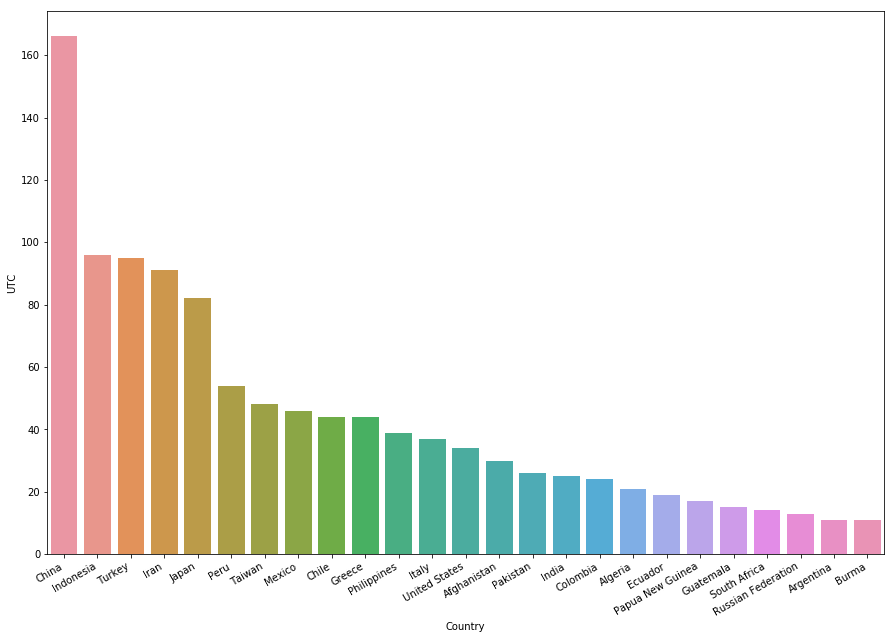

In [12]:
quakes_country_25 = earthquakes.groupby("Country").agg(len).reset_index().nlargest(25, columns="UTC")

f, ax = plt.subplots(figsize=(15, 10))
#plt.ylabel('Number of Quakes')
quake_count = sns.barplot(x='Country', y='UTC', data=quakes_country_25)
quake_count.set_xticklabels(quake_count.get_xticklabels(), rotation=30, ha="right")

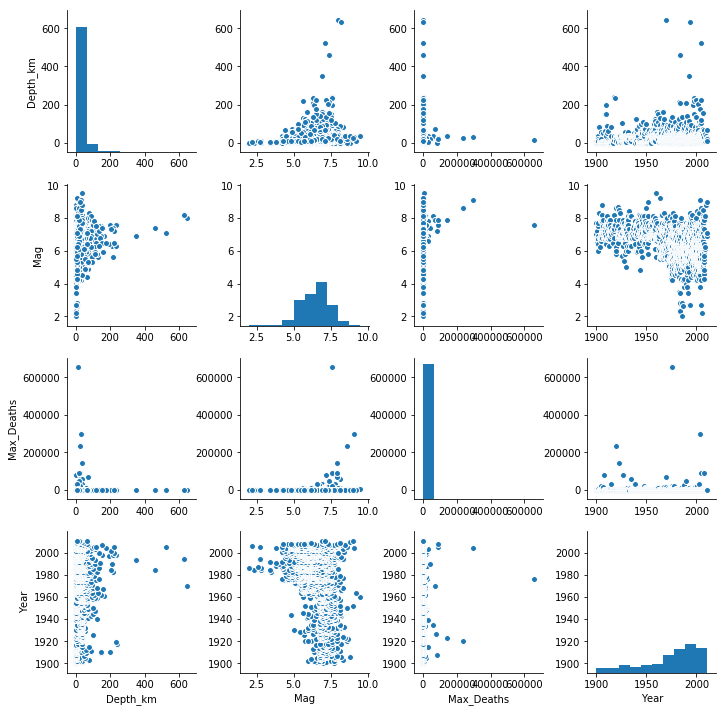

In [13]:
"""Trying to find any correlation between these columns. Most interesting find is between Depth and Mag"""
earthquakes_cont = earthquakes[["Depth_km", "Mag", "Max_Deaths", "Year"]]
earthquakes_cont = earthquakes_cont.replace("?", np.nan)
earthquakes_cont["Depth_km"] = pd.to_numeric(earthquakes_cont["Depth_km"])
earthquakes_cont = earthquakes_cont.dropna()

sns.pairplot(earthquakes_cont, dropna=True)

In [14]:
# Total deaths by country
occurrence_death = earthquakes[['Country', 'Max_Deaths']].groupby(['Country']).agg(['sum', 'count'])
occurrence_death.columns=['Total Deaths', 'Frequency of Earthquakes']

EQ_Casualities = occurrence_death.sort_values(['Frequency of Earthquakes'], ascending=False)
EQ_Casualities.head()

,Total Deaths,Frequency of Earthquakes
Country,,
China,1138388.0,166
Indonesia,342112.0,96
Turkey,90836.0,95
Iran,152664.0,91
Japan,166997.0,82


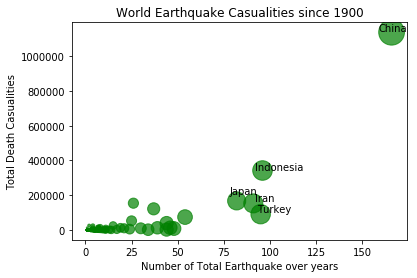

In [15]:
# Base size of dots based on frequency
np_death = np.array(EQ_Casualities['Frequency of Earthquakes'])
np_death = np_death*4

# Find correlation between Frequency and Total Deaths
plt.scatter(EQ_Casualities['Frequency of Earthquakes'], EQ_Casualities['Total Deaths'], s=np_death, color='green', alpha=0.7)

# Hard code some labels
plt.text(159, 1143382.0, 'China')
plt.text(93, 103304.0, 'Turkey')
plt.text(92, 167960.0, 'Iran')
plt.text(92, 343574.0, 'Indonesia')
plt.text(78, 205148.0, 'Japan')

plt.xlabel('Number of Total Earthquake over years')
plt.ylabel('Total Death Casualities')

plt.title('World Earthquake Casualities since 1900')

plt.show()

In [16]:
# convert lat and lng to numeric, then create geometry df
earthquakes["lat"] = pd.to_numeric(earthquakes["lat"])
earthquakes["lng"] = pd.to_numeric(earthquakes["lng"])

earthquakes.drop("UTC", inplace=True, axis=1)

geometry = [Point(xy) for xy in zip(earthquakes.lng, earthquakes.lat)]
crs = {"init": "epsg:4326"} 
earthquakes_gdf = gpd.GeoDataFrame(earthquakes, crs=crs, geometry=geometry)

In [17]:
volcanoes.columns = ["Name", "Country", "Type", "lat", "lng", "Elevation"]

# Cleaning a few rows in the df
new_lines_spaces = "(\n|\n\s)"
volcanoes = volcanoes.replace(to_replace=new_lines_spaces, value="", regex=True)

# Cleaning up some extra spaces 
volcanoes["lat"] = volcanoes["lat"].str.strip()
volcanoes["lng"] = volcanoes["lng"].str.strip()
volcanoes["Elevation"] = volcanoes["Elevation"].str.strip()

In [18]:
# Convert appropriate rows to numeric
volcanoes["lat"] = pd.to_numeric(volcanoes["lat"])
volcanoes["lng"] = pd.to_numeric(volcanoes["lng"])
volcanoes["Elevation"] = pd.to_numeric(volcanoes["Elevation"])

In [19]:
# Create a geometry column for graphing later
geometry = [Point(xy) for xy in zip(volcanoes.lng, volcanoes.lat)]
crs = {"init": "epsg:4326"} 
volcanoes_gdf = gpd.GeoDataFrame(volcanoes, crs=crs, geometry=geometry)

In [20]:
# Some basic cleaning of the rows
vents = vents.replace(to_replace=new_lines_spaces, value="", regex=True)

# Renaming columns
vents.columns = ["Name", "Activity", "Tectonic Setting", "Region", "lat", "lng", "Depth", "Year&Discovered"]

# Removing all extra spaces from these rows
vents["lat"] = vents["lat"].str.strip()
vents["lng"] = vents["lng"].str.strip()
vents["Year&Discovered"] = vents["Year&Discovered"].str.strip()

# Turn appropriate columns qto numeric
cols = ["lat", "lng", "Depth"]
vents[cols] = vents[cols].apply(pd.to_numeric)#, errors='coerce')

# Create a new geometry column to plot with lata
geometry_vent = [Point(xy) for xy in zip(vents.lng, vents.lat)]
crs = {"init": "epsg:4326"} 
vents_gdf = gpd.GeoDataFrame(vents, crs=crs, geometry=geometry_vent)

In [21]:
# Import plates and countries geojson to plot
plates_gdf = gpd.read_file("MR_Data/PB2002_plates.json")
countries_gdf = gpd.read_file("MR_Data/countries.geojson")

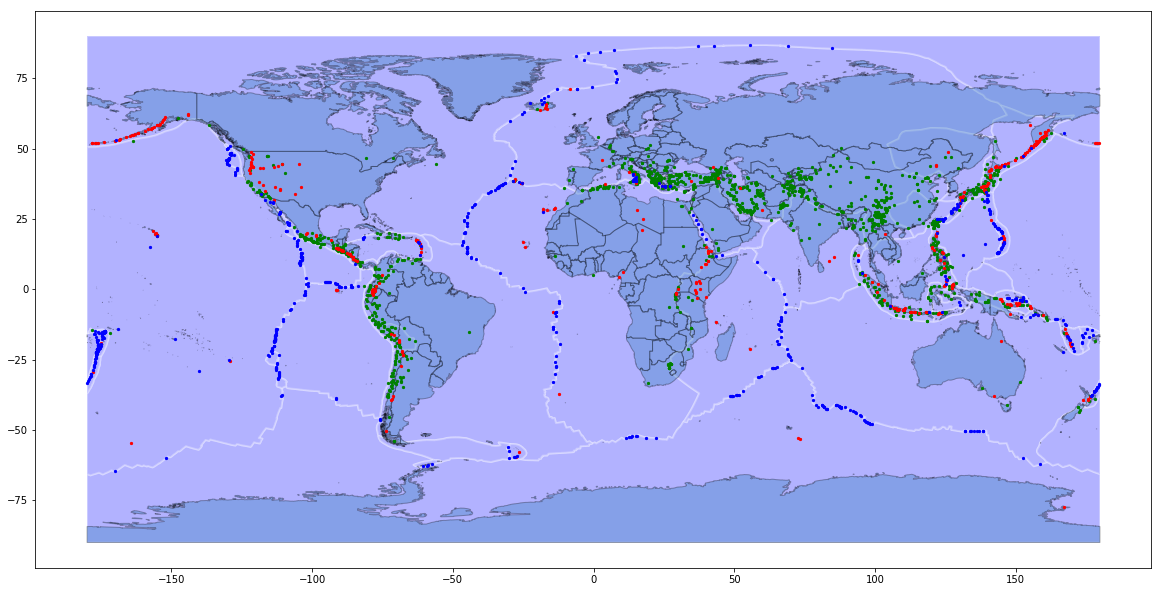

In [22]:
fig, ax = plt.subplots(figsize=(20, 20))
ax.set_aspect('equal')

# Countries and plates
plates_gdf.plot(ax=ax, color='blue', edgecolor='white', alpha=0.3, lw=2.0)
countries_gdf.plot(ax=ax, edgecolor='black', alpha=0.3)

# all points (earthquakes, volcanoes, and vents)
earthquakes_gdf.plot(ax=ax, markersize=5, color="green")
volcanoes_gdf.plot(ax=ax, markersize=5, color="red")
vents_gdf.plot(ax=ax, markersize=5, color="blue")

In [23]:
# Now that we have our data plotted out, we want to categorize the earthquakes based on location. 
# How close are they to the plates, and which plates are they closest to?
boundaries_gdf = gpd.read_file("MR_Data/PB2002_steps.json")

In [24]:
# We are wanting to grab the geometry columns per type of volcano
def get_geometries_from_gdf(df, column, category_list):    
    geometry_types = list()
    for df_type in category_list:
        if df_type == 'None':
            df_type_geometry = df[df[column].str.contains("")].geometry
        else: 
            df_type_geometry = df[df[column].str.contains(df_type)].geometry

        geometry_types.append(df_type_geometry)
    
    return geometry_types

In [25]:
# Get geometry column as series per type of volcano
vol_types = ["Stratovolcano", "Caldera", "Shield", "Complex Volcano", "Submarine", "Volcanic Field", "Cinder Cone", "Dome",
        "Fissure vents", "Somma Volcano", "Maar", "Pyroclastic Cone", "Tuff Ring", "Plug", "None"]

vol_series_geometry_list = get_geometries_from_gdf(volcanoes_gdf, 'Type', vol_types)
vol_series_geometry_list.extend([volcanoes_gdf.geometry])

In [26]:
# Grab geometry from earthquakes
earthquakes_geo = earthquakes_gdf["geometry"]

In [27]:
def quake_distance(geoseries):
    dist_list = []
    for quake in earthquakes_geo:
        dist = np.min([quake.distance(vol) for vol in geoseries])
        dist_list.append(dist)
        
    return dist_list

In [28]:
total_dist_list = []

for geoseries in vol_series_geometry_list:
    dist_list = quake_distance(geoseries)
    total_dist_list.append(dist_list)

In [29]:
vol_dist = pd.DataFrame(total_dist_list)
vol_dist = vol_dist.transpose()

vol_dist.columns = vol_types + ["vol"]

quake_vol_dist = pd.concat([earthquakes_gdf, vol_dist], axis=1)

In [30]:
# Determining closest volcano to earthquake
conditions = list()
for col in vol_types:
    if not col == 'vol':
        dist_bool = (quake_vol_dist['vol'] == quake_vol_dist[col])
        conditions.append(dist_bool)

quake_vol_dist['closest_vol'] = np.select(conditions, vol_types, default=np.nan)

[Text(0,0,'Stratovolcano'),
 Text(0,0,'Caldera'),
 Text(0,0,'Shield'),
 Text(0,0,'Complex Volcano'),
 Text(0,0,'Submarine'),
 Text(0,0,'Volcanic Field'),
 Text(0,0,'Cinder Cone'),
 Text(0,0,'Dome'),
 Text(0,0,'Fissure vents'),
 Text(0,0,'Somma Volcano'),
 Text(0,0,'Maar'),
 Text(0,0,'Pyroclastic Cone'),
 Text(0,0,'Tuff Ring'),
 Text(0,0,'Plug')]

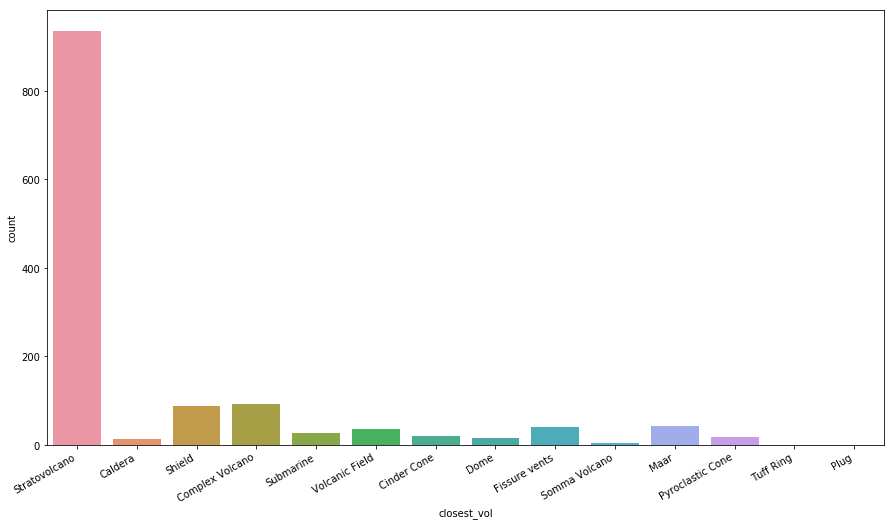

In [31]:
# At this point, we are wanting to visualize the distances between volcanoes and earthquakes. Notice here 
# how strato is way higher than the rest. This, we found, is a normalization issue. 
plt.subplots(figsize=(15, 8))
closest_vol_plot = sns.countplot(quake_vol_dist["closest_vol"])
closest_vol_plot.set_xticklabels(labels=vol_types, rotation=30, ha='right')

In [32]:
# Doing a quick value count, we are able to assert that our hypothesis is correct. Strato is way higher than the rest, 
# skewing our data.
dict(quake_vol_dist["closest_vol"].value_counts())

{'Caldera': 92,
 'Cinder Cone': 19,
 'Complex Volcano': 41,
 'Dome': 89,
 'Fissure vents': 5,
 'Maar': 1,
 'None': 15,
 'Plug': 1,
 'Pyroclastic Cone': 44,
 'Shield': 36,
 'Somma Volcano': 21,
 'Stratovolcano': 936,
 'Submarine': 13,
 'Volcanic Field': 27}

In [33]:
dict(volcanoes_gdf['Type'].value_counts())

{'': 10,
 '            Caldera          ': 40,
 '            Cinder Cone          ': 9,
 '            Complex Volcano          ': 16,
 '            Dome          ': 8,
 '            Fissure vents          ': 4,
 '            Flood Basalt          ': 2,
 '            Maar          ': 3,
 '            Plug          ': 1,
 '            Pyroclastic Cone          ': 3,
 '            Shield          ': 34,
 '            Somma Volcano          ': 3,
 '            Stratovolcano          ': 275,
 '            Submarine          ': 11,
 '            Tuff Ring          ': 1,
 '            Volcanic Field          ': 11}

In [34]:
quakes_closest = dict(quake_vol_dist["closest_vol"].value_counts())
volcanoes = dict(volcanoes_gdf['Type'].value_counts())

to_np = list()
for key, value in volcanoes.items():
    key = key.strip()
    compare = dict(
        type=key,
        volcanoes=value
    )
    
    compare['earthquakes'] = quakes_closest.get(key, 0)
    
    to_np.append(compare)

to_np

[{'earthquakes': 936, 'type': 'Stratovolcano', 'volcanoes': 275},
 {'earthquakes': 92, 'type': 'Caldera', 'volcanoes': 40},
 {'earthquakes': 36, 'type': 'Shield', 'volcanoes': 34},
 {'earthquakes': 41, 'type': 'Complex Volcano', 'volcanoes': 16},
 {'earthquakes': 13, 'type': 'Submarine', 'volcanoes': 11},
 {'earthquakes': 27, 'type': 'Volcanic Field', 'volcanoes': 11},
 {'earthquakes': 0, 'type': '', 'volcanoes': 10},
 {'earthquakes': 19, 'type': 'Cinder Cone', 'volcanoes': 9},
 {'earthquakes': 89, 'type': 'Dome', 'volcanoes': 8},
 {'earthquakes': 5, 'type': 'Fissure vents', 'volcanoes': 4},
 {'earthquakes': 1, 'type': 'Maar', 'volcanoes': 3},
 {'earthquakes': 44, 'type': 'Pyroclastic Cone', 'volcanoes': 3},
 {'earthquakes': 21, 'type': 'Somma Volcano', 'volcanoes': 3},
 {'earthquakes': 0, 'type': 'Flood Basalt', 'volcanoes': 2},
 {'earthquakes': 1, 'type': 'Plug', 'volcanoes': 1},
 {'earthquakes': 0, 'type': 'Tuff Ring', 'volcanoes': 1}]

In [35]:
"""CORRECTING FOR DIFFERENCES IN NUM OF VOLCANOES"""
# distance count as shown above
type_list = list()
dist_count = list()
vol_count = list()
for vol_type in to_np:
    dist_count.append(vol_type['earthquakes'])
    vol_count.append(vol_type['volcanoes'])
    type_list.append(vol_type['type'])
    

dist_count = np.array(dist_count)
# value count of the original dataframe
vol_count = np.array(vol_count)

normalized_dist = np.divide(dist_count, vol_count)

Text(0,0.5,'normalized distance')

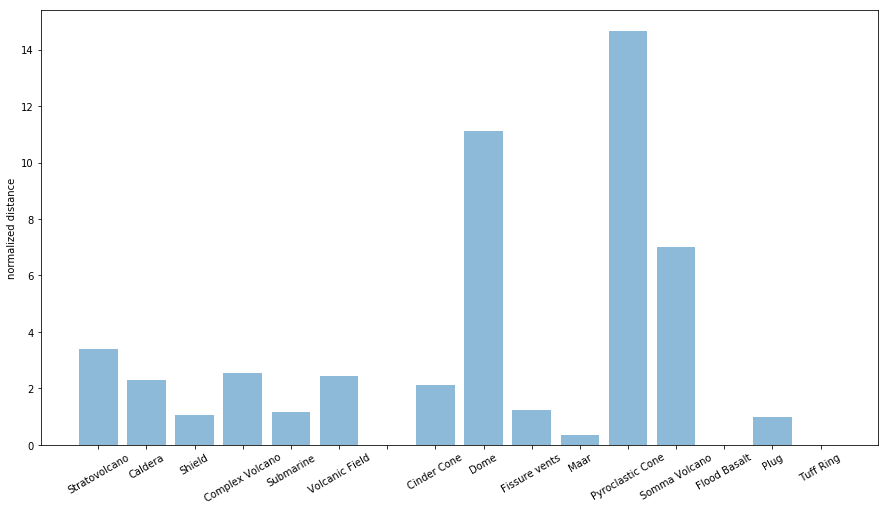

In [36]:
# Plotting out the normalized distances
# Notice the difference in the graph. Pyroclastic very obviously stands out
y_pos = np.arange(len(normalized_dist))
 
plt.figure(figsize=(15,8))
plt.bar(y_pos, normalized_dist, alpha=0.5)
plt.xticks(y_pos, type_list, rotation=30)
plt.ylabel('normalized distance')

[Text(0,0,'Stratovolcano'),
 Text(0,0,'Caldera'),
 Text(0,0,'Shield'),
 Text(0,0,'Complex Volcano'),
 Text(0,0,'Submarine'),
 Text(0,0,'Volcanic Field'),
 Text(0,0,''),
 Text(0,0,'Cinder Cone'),
 Text(0,0,'Dome'),
 Text(0,0,'Fissure vents'),
 Text(0,0,'Maar'),
 Text(0,0,'Pyroclastic Cone'),
 Text(0,0,'Somma Volcano'),
 Text(0,0,'Flood Basalt')]

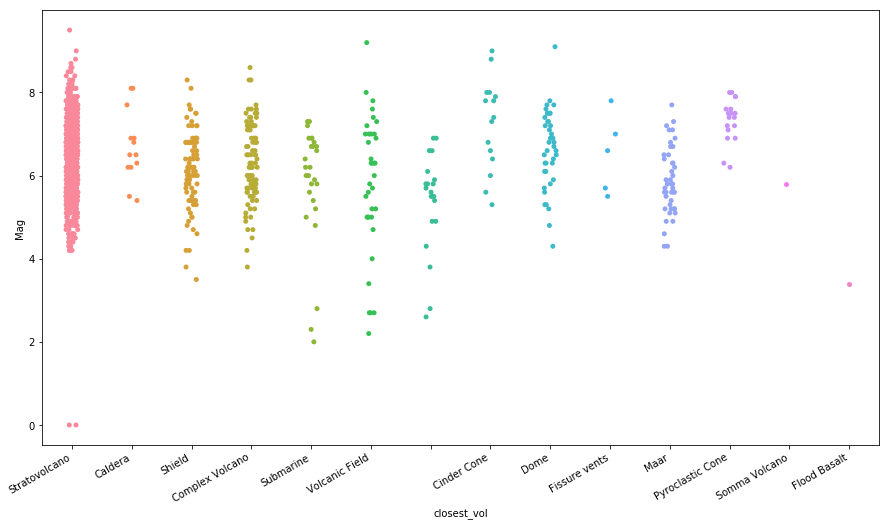

In [37]:
# Strip plot showing correlations between Magnitude and the Closest Volcano
plt.figure(figsize=(15,8))

sp = sns.stripplot(x="closest_vol", y="Mag", data=quake_vol_dist, jitter=True)
sp.set_xticklabels(labels=type_list, rotation=30, ha="right")

In [38]:
# Get geometry column as series per type of plate
plate_types = ["SUB", "CCB", "CRB", "CTF", "OCB", "OSR", "OTF"]

plates_series_geometry_list = get_geometries_from_gdf(boundaries_gdf, 'STEPCLASS', plate_types)
plates_series_geometry_list.extend([boundaries_gdf.geometry])

In [39]:
plate_dist_list = []

for geoseries in plates_series_geometry_list:
    dist_list = quake_distance(geoseries)
    plate_dist_list.append(dist_list)

In [40]:
plate_dist = pd.DataFrame(plate_dist_list)
plate_dist = plate_dist.transpose()

plate_dist.columns = plate_types + ["plates"]

quake_plate_dist = pd.concat([earthquakes_gdf, plate_dist], axis=1)

In [41]:
# Determining closest volcano to earthquake
conditions = list()
for col in plate_types:
    dist_bool = (quake_plate_dist['plates'] == quake_plate_dist[col])
    conditions.append(dist_bool)

quake_plate_dist['closest_plate'] = np.select(conditions, plate_types, default=np.nan)

In [42]:
boundary_distances_gdf = gpd.GeoDataFrame(
    quake_plate_dist, 
    crs={'init': 'epsg:4326'}, 
    geometry=earthquakes_gdf.geometry
)

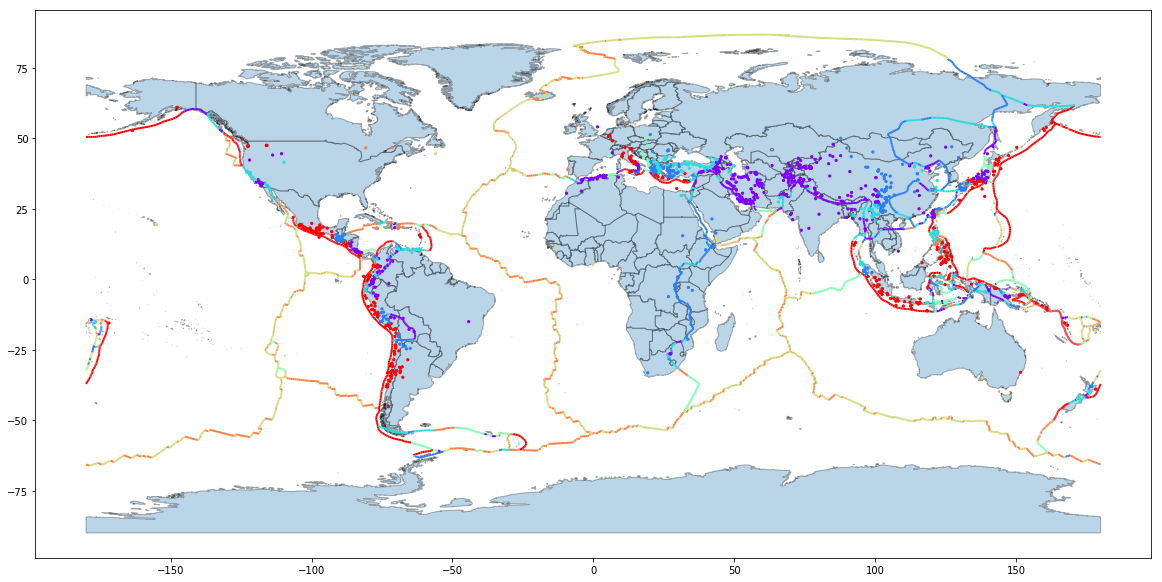

In [43]:
fig, ax = plt.subplots(figsize=(20, 20))
ax.set_aspect('equal')

# Countries and plates
boundaries_gdf.plot(ax=ax, column='STEPCLASS', cmap='rainbow', lw=2.0)
countries_gdf.plot(ax=ax, edgecolor='black', alpha=0.3)

# all points (earthquakes, volcanoes, and vents)
boundary_distances_gdf.plot(ax=ax, column='closest_plate', cmap='rainbow', markersize=5)